In [112]:
import os
import requests
import pandas as pd
import numpy as np 
import seaborn as sns 
!pip install hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
!pip install finta
!pip install yfinance
!pip install YahooFinancials
#!pip install fdpf
!pip install MCSimulation
from MCForecastTools import MCSimulation
import yfinance as yf
from finta import TA

%matplotlib inline
#streamlit or tableau of 


ERROR: Could not find a version that satisfies the requirement MCSimulation (from versions: none)
ERROR: No matching distribution found for MCSimulation


ModuleNotFoundError: No module named 'MCForecastTools'

In [113]:
import yfinance as yf
from yahoofinancials import YahooFinancials

In [122]:
def read_data(data, start, end):
    data1_df = yf.download(data, start, end)
    data1_df.dropna(inplace = True)
    dataclose1_df = data1_df
    return dataclose1_df

In [123]:
xeroasx = read_data(['XRO.AX'], "2013-01-01","2022-07-28")

[*********************100%***********************]  1 of 1 completed


In [124]:
xeroasx

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,6.000000,6.000000,5.750000,5.860000,5.860000,9780
2013-01-03,5.950000,6.000000,5.860000,5.960000,5.960000,10541
2013-01-04,5.930000,5.930000,5.900000,5.900000,5.900000,10360
2013-01-07,5.900000,5.930000,5.800000,5.890000,5.890000,30312
2013-01-08,5.920000,6.000000,5.890000,6.000000,6.000000,14448
...,...,...,...,...,...,...
2022-07-21,88.000000,90.809998,87.290001,90.500000,90.500000,610120
2022-07-22,90.750000,93.120003,89.360001,91.220001,91.220001,684767
2022-07-25,90.440002,90.980003,88.720001,90.260002,90.260002,608109


In [125]:
# Removing columns other than 'Close' from the dataframe
xeroasx = xeroasx.drop(['Open', 'High', 'Low', 'Volume'], axis = 1)

xeroasx.tail()

,Close,Adj Close
Date,,
2022-07-21,90.500000,90.500000
2022-07-22,91.220001,91.220001
2022-07-25,90.260002,90.260002
2022-07-26,89.129997,89.129997
2022-07-27,89.589996,89.589996


In [126]:
# Set 9 as the lookback period of the short-term moving average
shortterm_lookback = 9

# Set 21 as the lookback period of the long-term moving average
longterm_lookback = 21

# Store short-term moving average values in the column 'ma_short'
xeroasx['ma_short'] = xeroasx.Close.rolling(shortterm_lookback).mean()

# Store long-term moving average values in the column 'ma_long'
xeroasx['ma_long'] = xeroasx.Close.rolling(longterm_lookback).mean()

xeroasx.tail()

,Close,Adj Close,ma_short,ma_long
Date,,,,
2022-07-21,90.500000,90.500000,86.254445,83.390952
2022-07-22,91.220001,91.220001,87.027778,84.095714
2022-07-25,90.260002,90.260002,87.692223,84.481905
2022-07-26,89.129997,89.129997,88.106667,84.767619
2022-07-27,89.589996,89.589996,88.382222,85.101904


In [127]:
# Create a column 'signal' to store the relative position of moving averages
xeroasx['signal'] = np.where(xeroasx.ma_short > xeroasx.ma_long, 1, 0)

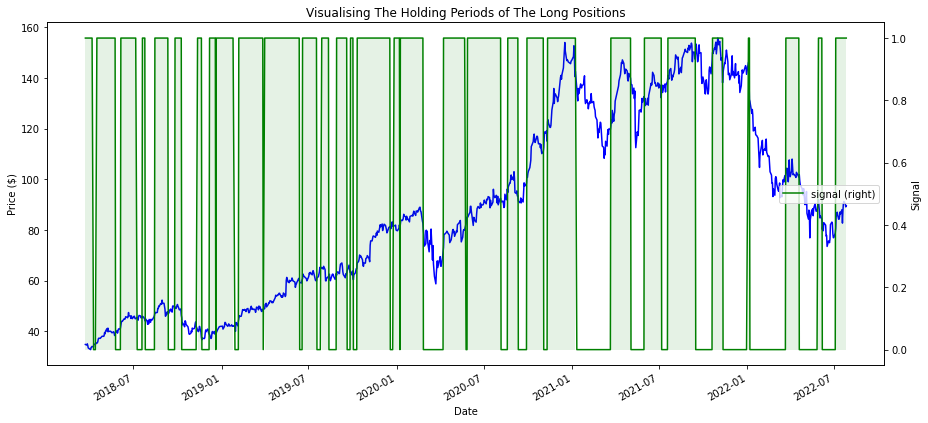

In [128]:
days = 1100

# Plot the close prices of the last 100 days
close_plot = xeroasx.Close[-days:].plot(figsize=(15, 7), color='blue')

# Plot the signal of the last 100 days
signal_plot = xeroasx.signal[-days:].plot(figsize=(15, 7),
                                       secondary_y=True, ax=close_plot, style='green')

# Highlight the holding periods of the long positions
plt.fill_between(xeroasx.Close[-days:].index, 0, 1,
                 where=(xeroasx.signal[-days:] > 0), color='green', alpha=0.1, lw=0)

# Title of the plot
signal_plot.set_title('Visualising The Holding Periods of The Long Positions')

# Plot ylabels
close_plot.set_ylabel('Price ($)')
signal_plot.set_ylabel('Signal')

# Legend of the plot
plt.legend()

# Show the plot
plt.show()

In [129]:
# Calculate strategy returns
strategy_returns = xeroasx.signal.shift(1)*xeroasx.Close.pct_change()

# Total strategy returns
print(f'Total strategy returns: {strategy_returns.sum():.2f} %')

Total strategy returns: 3.43 %


In [130]:
# Create a column 'long_cross_over' to store the long crossover conditions
xeroasx['long_cross_over'] = np.where((xeroasx.ma_short.shift(
    1) < xeroasx.ma_long.shift(1)) & (xeroasx.ma_short >= xeroasx.ma_long), True, False)

In [131]:
# Create a column 'exit_cross_over' to store the long exit conditions
xeroasx['exit_cross_over'] = np.where((xeroasx.ma_short.shift(
    1) > xeroasx.ma_long.shift(1)) & (xeroasx.ma_short <= xeroasx.ma_long), True, False)
xeroasx.tail()

,Close,Adj Close,ma_short,ma_long,signal,long_cross_over,exit_cross_over
Date,,,,,,,
2022-07-21,90.500000,90.500000,86.254445,83.390952,1,False,False
2022-07-22,91.220001,91.220001,87.027778,84.095714,1,False,False
2022-07-25,90.260002,90.260002,87.692223,84.481905,1,False,False
2022-07-26,89.129997,89.129997,88.106667,84.767619,1,False,False
2022-07-27,89.589996,89.589996,88.382222,85.101904,1,False,False


In [132]:
# Create a dataframe 'trade_sheet' to store the trades
trade_sheet = pd.DataFrame()

In [133]:
# Initialise the current_position as '0' ie we dont hold any assets yet 
current_position = 0

In [134]:
# Define a variable to store the long entry date
entry_date = ''

# Define a variable to store the long entry price
entry_price = ''

# Define a variable to store the long exit date
exit_date = ''

# Define a variable to store the long exit price
exit_price = ''

In [136]:
def backtest_trade_sheet(xeroasx, close_column, long_crossover_column, exit_crossover_column):
    # Create a dataframe 'trade_sheet' to store the trades
    trade_sheet = pd.DataFrame()

    # Initialise the current_position as '0'
    current_position = 0

    # Define a variable to store the long entry date
    entry_date = ''

    # Define a variable to store the long entry price
    entry_price = ''

    # Define a variable to store the long exit date
    exit_date = ''

    # Define a variable to store the long exit price
    exit_price = ''

    # Iterate over the dates in the dataframe 'data' 
    for current_date in xeroasx.index:

        # Define the variable 'long_crossover' that stores the long crossover condition on the current_date
        long_crossover = xeroasx.loc[current_date, long_crossover_column]

        # Define the variable 'exit_crossover' that stores the exit crossover value on date current_date
        exit_crossover = xeroasx.loc[current_date, exit_crossover_column]

        # We will enter the long position if we are not holding any position and entry condition is met
        if current_position == 0 and long_crossover == True:

            # Define the variable 'entry_date'
            entry_date = current_date

            # Extract the 'Close price' on the current_date and store in the variable 'entry price'
            entry_price = xeroasx.loc[entry_date, close_column]

            # Since a new long position is opened, change the state of current_position to '1'
            current_position = 1

        # We will exit the long position if we are holding long position and exit condition is met
        elif current_position == 1 and exit_crossover == True:

            # Define the variable 'exit_date'
            exit_date = current_date

            # Extract the 'Close price' on the current_date and store in the variable 'exit price'
            exit_price = xeroasx.loc[exit_date, close_column]

            # Append the details of this trade to the 'trades' dataframe
            trade_sheet = trade_sheet.append(
                [(current_position, entry_date, entry_price, exit_date, exit_price)], ignore_index=True)

            # Since a new long position is closed, change the state of current_position to '0'
            current_position = 0

    # Define the names of columns in 'trades' dataframe
    trade_sheet.columns = ['Position', 'Entry Date',
                           'Entry Price', 'Exit Date', 'Exit Price']
    # Return the trades dataframe
    return trade_sheet

In [137]:
# Save the trades generated in the dataframe 'crossover_trade_sheet'
crossover_trade_sheet = backtest_trade_sheet(
    xeroasx, 'Close', 'long_cross_over', 'exit_cross_over')

# Calculate PnL for each trade
crossover_trade_sheet['PnL'] = (crossover_trade_sheet['Exit Price'] -
                                crossover_trade_sheet['Entry Price']) * crossover_trade_sheet['Position']

# Print the total profit/loss by summing up the PnL of each trade.
print(f'The total PnL of trades generated between 2010-01-01 and 2022-05-31 is $',
      round(crossover_trade_sheet.PnL.sum(), 2))

# Print the last 5 rows of the 'crossover_trade_sheet' dataframe
crossover_trade_sheet.tail()

The total PnL of trades generated between 2010-01-01 and 2022-05-31 is $ 95.28


,Position,Entry Date,Entry Price,Exit Date,Exit Price,PnL
56,1,2021-07-20,141.000000,2021-09-16,150.789993,9.789993
57,1,2021-10-21,150.050003,2021-11-12,142.259995,-7.790009
58,1,2022-01-04,146.220001,2022-01-07,130.830002,-15.389999
59,1,2022-03-23,102.930000,2022-04-20,101.830002,-1.099998
60,1,2022-05-30,92.019997,2022-06-07,80.190002,-11.829994


In [138]:
# Create dataframe to store trade analytics
analytics = pd.DataFrame(index=['Analyse'])

In [139]:
# Calculate total PnL
analytics['Total PnL'] = crossover_trade_sheet.PnL.sum() 

# Print the value
print("Total PnL: ",analytics['Total PnL'][0])

Total PnL:  95.2799711227417


In [140]:
# Number of total trades
analytics['total_trades'] = len(crossover_trade_sheet.loc[crossover_trade_sheet.Position==1])

In [141]:
# Winning trades
analytics['Number of Winners'] = len(crossover_trade_sheet.loc[crossover_trade_sheet.PnL>0])

# Loosing trades
analytics['Number of Losers'] = len(crossover_trade_sheet.loc[crossover_trade_sheet.PnL<=0])

In [142]:
# Winning percentage
analytics['Win (%)'] = 100*analytics['Number of Winners']/analytics.total_trades

# Lossing percentage
analytics['Loss (%)'] = 100*analytics['Number of Losers']/analytics.total_trades



analytics.T

,Analyse
Total PnL,95.279971
total_trades,61.000000
Number of Winners,31.000000
Number of Losers,30.000000
Win (%),50.819672
Loss (%),49.180328


In [143]:
# Create a dataframe to store performance metrics
performance_metrics = pd.DataFrame(index=['Outcomes'])

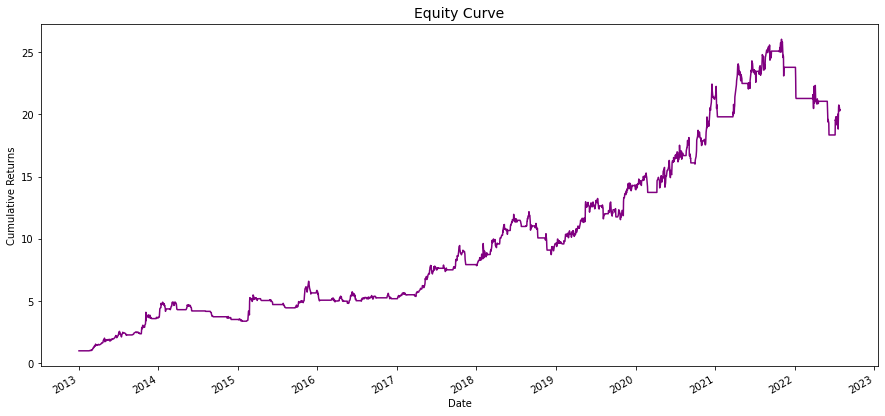

In [144]:
# Calculate strategy returns
xeroasx['Strategy_Returns'] = xeroasx.signal.shift(1) * xeroasx.Close.pct_change()

# Calculate cumulative strategy returns
xeroasx['Cumulative_Returns'] = (xeroasx['Strategy_Returns'] + 1.0).cumprod()

# Plot the cumulative strategy returns
(xeroasx['Cumulative_Returns'].plot(figsize=(15, 7), color='purple'))
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative Returns')
plt.show()

In [145]:
# Total number of trading days
days = len(xeroasx['Cumulative_Returns'])

# Calculate compounded annual growth rate
performance_metrics['CAGR'] = "{0:.2f}%".format(
    (xeroasx.Cumulative_Returns.iloc[-1]**(252/days)-1)*100)

# Calculate annualised volatility
performance_metrics['Annualised Volatility'] = "{0:.2f}%".format(
    xeroasx['Strategy_Returns'].std()*np.sqrt(252) * 100)

# Set a risk-free rate
risk_free_rate = 0.02/365

# Calculate Sharpe ratio
performance_metrics['Sharpe Ratio'] = np.sqrt(252)*(np.mean(xeroasx.Strategy_Returns) -
                                                    (risk_free_rate))/np.std(xeroasx.Strategy_Returns)

# Compute the cumulative max drawdown
xeroasx['Peak'] = xeroasx['Cumulative_Returns'].cummax()

# Compute the Drawdown
xeroasx['Drawdown'] = ((xeroasx['Cumulative_Returns']-xeroasx['Peak'])/xeroasx['Peak'])

# Compute the maximum drawdown
performance_metrics['Maximum Drawdown'] =  "{0:.2f}%".format((xeroasx['Drawdown'].min())*100)

performance_metrics.T

,Outcomes
CAGR,36.82%
Annualised Volatility,29.62%
Sharpe Ratio,1.157927
Maximum Drawdown,-31.66%


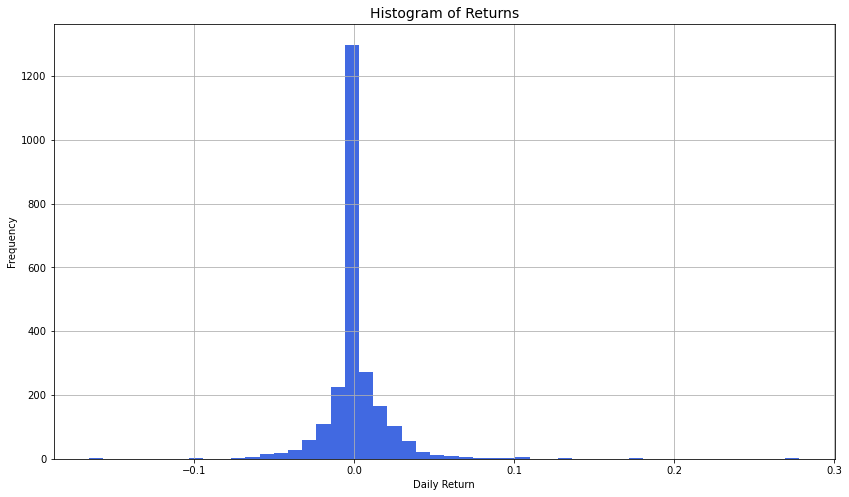

In [146]:
# Plot a returns histogram
xeroasx.Strategy_Returns.hist(bins=50, figsize=(14, 8), color='royalblue')
plt.title('Histogram of Returns', fontsize=14)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

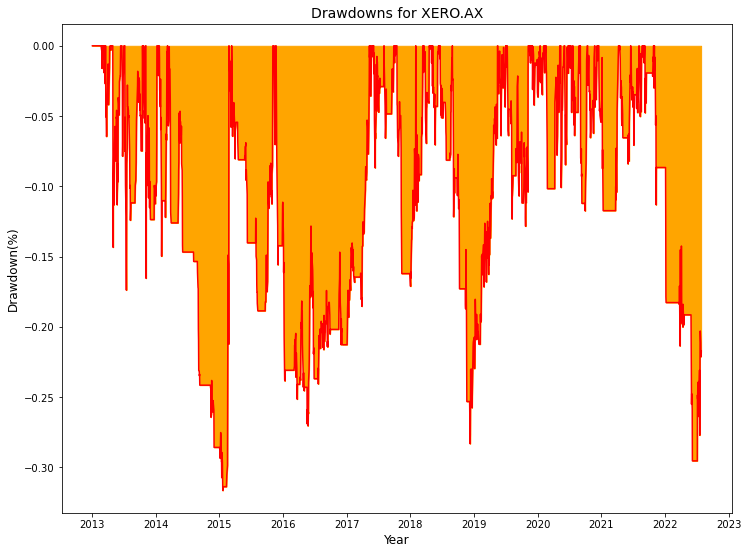

In [147]:
# Define size of graph
plt.figure(figsize=(12, 9))

# Set the title and axis labels
plt.title('Drawdowns for XERO.AX', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

# Plot max drawdown
plt.plot(xeroasx['Drawdown'], color='red')

# Fill in-between the drawdown
plt.fill_between(xeroasx['Drawdown'].index, xeroasx['Drawdown'].values, color='orange')
plt.show()

In [148]:
# Step-1: Create a dataframe 'trade_sheet' to store the trades
trade_sheet = pd.DataFrame()

In [149]:
# Step-2: Initialise the current_position as '0'
current_position = 0

In [150]:
#Step-3:
# Define a variable to store the long entry date
entry_date = ''

# Define a variable to store the long entry price
entry_price = ''

# Define a variable to store the long exit date
exit_date = ''

# Define a variable to store the long exit price
exit_price = ''

# Define a variable to store the stop loss percentage
stop_loss_percentage = 0.09

# Define a variable to store the take profit percentage
take_profit_percentage = 0.15

In [151]:
# Iterate over the dates in the dataframe 'data'
for current_date in xeroasx.index:

    # Define the variable 'long_crossover' that stores the long crossover condition on the current_date
    long_crossover = xeroasx.loc[current_date, 'long_cross_over']

    # Define the variable 'exit_crossover' that stores the exit crossover value on date current_date
    exit_crossover = xeroasx.loc[current_date, 'exit_cross_over']

    # Step-4: Check if we are holding a long position, we will check for stop-loss and take-profit breach
    if (current_position == 1):

        # Stop-loss = entry_price - (entry_price * stop_loss_percentage)
        stop_loss = entry_price * (1-stop_loss_percentage)

        # Take-profit = entry_price + (entry_price * take_profit_percentage)
        take_profit = entry_price * (1+take_profit_percentage)
        
        # stop-loss condition        
        stop_loss_breach = xeroasx.loc[current_date, 'Close'] <= stop_loss
        
        # take-profit condition        
        take_profit_breach = xeroasx.loc[current_date, 'Close'] >= take_profit        
        
        
        # if low is below stop-loss or high is above take-profit
        if stop_loss_breach or take_profit_breach:

            # Define the variable 'exit_date'
            exit_date = current_date

            # Extract the 'Close price' on the current_date and store in the variable 'exit price'
            exit_price = xeroasx.loc[exit_date, 'Close']

            # Exit type if 'Stop-Loss' if stop-loss was breached and 'Take-Profit' if take-profit was breached
            exit_type = "Stop-Loss" if stop_loss_breach else "Take-Profit"

            # Append the details of this trade to the 'trade_sheet' dataframe
            trade_sheet = trade_sheet.append(
                [(current_position, entry_date, entry_price, exit_date, exit_price, exit_type)], ignore_index=True)

            # Since a new long position is closed, change the state of current_position to '0'
            current_position = 0
    # Step-5: We will enter the long position if we are not holding any position and entry condition is met
    if current_position == 0 and long_crossover == True:

        # Define the variable 'entry_date'
        entry_date = current_date

        # Extract the 'Close price' on the current_date and store in the variable 'entry price'
        entry_price = xeroasx.loc[entry_date, 'Close']

        # Since a new long position is opened, change the state of current_position to '1'
        current_position = 1

    # Step-6: We will exit the long position if we are holding long position and exit condition is met
    elif current_position == 1 and exit_crossover == True:

        # Define the variable 'exit_date'
        exit_date = current_date

        # Extract the 'Close price' on the current_date and store in the variable 'exit price'
        exit_price = xeroasx.loc[exit_date, 'Close']        

        # Exit type is 'exit_crossover'
        exit_type = 'exit_crossover'

        # Append the details of this trade to the 'trade_sheet' dataframe
        trade_sheet = trade_sheet.append(
            [(current_position, entry_date, entry_price, exit_date, exit_price, exit_type)], ignore_index=True)

        # Since a new long position is closed, change the state of current_position to '0'
        current_position = 0

# Define the names of columns in 'trade_sheet' dataframe
trade_sheet.columns = ['Position', 'Entry Date',
                  'Entry Price', 'Exit Date', 'Exit Price', 'Exit Type']

trade_sheet.tail()

,Position,Entry Date,Entry Price,Exit Date,Exit Price,Exit Type
56,1,2021-07-20,141.000000,2021-09-16,150.789993,exit_crossover
57,1,2021-10-21,150.050003,2021-11-12,142.259995,exit_crossover
58,1,2022-01-04,146.220001,2022-01-06,131.500000,Stop-Loss
59,1,2022-03-23,102.930000,2022-04-20,101.830002,exit_crossover
60,1,2022-05-30,92.019997,2022-06-07,80.190002,Stop-Loss


In [152]:
# Function to generate the trade sheet for strategy with stop-loss and take-profit

def backtest_trade_sheet_sl_tp(xeroasx, close_column, long_crossover_column,exit_crossover_column, stop_loss_percentage, take_profit_percentage):
    """Function to generate trade details
    """
    # Create a dataframe  to store the trades
    crossover_trade_sheet = pd.DataFrame()

    # Initialise the current_position as '0' since we don't hold any position at the beginning of the backtest
    current_position = 0

    # Iterate over the dates in the dataframe 'data'
    for current_date in xeroasx.index:
# Define the variable 'long_crossover' that stores the long crossover condition on current_date
        long_crossover = xeroasx.loc[current_date, long_crossover_column]

# Define the variable 'exit_crossover' that stores the exit crossover condition on current_date
        exit_crossover = xeroasx.loc[current_date, exit_crossover_column]

# Check if we are holding a long position
        if (current_position == 1):

        # Stop-loss = entry_price - (entry_price * stop_loss_percentage)
            stop_loss = entry_price * (1-stop_loss_percentage)

        # Take-profit = entry_price + (entry_price * take_profit_percentage)
            take_profit = entry_price * (1+take_profit_percentage)
            
        # stop-loss condition        
            stop_loss_breach = xeroasx.loc[current_date, close_column] <= stop_loss

        # take-profit condition        
            take_profit_breach = xeroasx.loc[current_date, close_column] >= take_profit        


        # if low is below stop-loss or high is above take-profit
        if stop_loss_breach or take_profit_breach:
                
            # Define the variable 'exit_date'
            exit_date = current_date

                # Extract exit price of the trade using the 'exit_date' and 'close_column' of dataframe 'data'
            exit_price = xeroasx.loc[exit_date, close_column]

                # Exit type if 'Stop-Loss' if stop-loss was breached and 'Take-Profit' if take-profit was breached
            exit_type = "Stop-Loss" if stop_loss_breach else "Take-Profit"

                # Append the details of this trade to the 'trades' dataframe
            crossover_trade_sheet = crossover_trade_sheet.append(
                    [(current_position, entry_date, entry_price, exit_date, exit_price, exit_type)], ignore_index=True)

                # Since a new long position is closed, change the state of current_position to '0'
            current_position = 0
        # We will enter the long position if we are not holding any position and entry condition is met
        if current_position == 0 and long_crossover > 0:

            # Define the variable 'entry_date'
            entry_date = current_date

            # Extract entry price of the trade using the 'entry_date' and 'close_column' of dataframe 'data'
            entry_price = xeroasx.loc[entry_date, close_column]

            # Since a new long position is opened, change the state of current_position to '1'
            current_position = 1

        # We will exit the long position if we are holding long position and exit condition is met
        elif current_position == 1 and exit_crossover > 0:

            # Define the variable 'exit_date'
            exit_date = current_date

            # Extract exit price of the trade using the 'exit_date' and 'close_column' of dataframe 'data'
            exit_price = xeroasx.loc[exit_date, close_column]

            # Exit type is 'Squareoff'
            exit_type = 'Squareoff'

            # Append the details of this trade to the 'trades' dataframe
            crossover_trade_sheet = crossover_trade_sheet.append(
                [(current_position, entry_date, entry_price, exit_date, exit_price, exit_type)], ignore_index=True)

            # Since a new long position is closed, change the state of current_position to '0'
            current_position = 0

    # Define the names of columns in 'trades' dataframe
    crossover_trade_sheet.columns = ['Position', 'Entry Date',
                      'Entry Price', 'Exit Date', 'Exit Price', 'Exit Type']

    # Return the xeroasxtrades dataframe
    return crossover_trade_sheet

In [153]:
# Using 9% as stop_loss_percentage and 15% as take_profit_percentage
# Save the trades generated in the dataframe 'crossover_trade_sheet'
crossover_trade_sheet_sl_tp = backtest_trade_sheet_sl_tp(
    xeroasx, 'Close', 'long_cross_over', 'exit_cross_over',  0.09, 0.15)

crossover_trade_sheet_sl_tp['PnL'] = (crossover_trade_sheet_sl_tp['Exit Price'] -
                     crossover_trade_sheet_sl_tp['Entry Price']) * crossover_trade_sheet_sl_tp['Position']

# Print the total profit/loss of the trades generated over the historical time period
print(f'The total PnL of trades generated between 2010-01-01 and 2022-05-31 is $',
      round(crossover_trade_sheet_sl_tp.PnL.sum(), 2))

# Print the last 5 rows of the 'crossover_trade_sheet_sl_tp' dataframe
crossover_trade_sheet_sl_tp.tail()



UnboundLocalError: local variable 'stop_loss_breach' referenced before assignment